In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/gm2offline_ana.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")
tcomp = f.Get("farline").Get("evwTree")
terr = f.Get("farline").Get("evwNoPartnerTree")

tcomp2 = f.Get("farline").Get("wveTree")
terr2 = f.Get("farline").Get("wveNoPartnerTree")

fwave = r.TFile("./data/waveforms.root")
twave = fwave.Get("islands").Get("islands").Get("islandTree")

In [3]:
teast.Print()

******************************************************************************
*Tree    :eastTree  : eastTree                                               *
*Entries :   270321 : Total =        64189330 bytes  File  Size =   22461437 *
*        :          : Tree compression factor =   2.86                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :   270321 : Total  Size=    1084891 bytes  File Size  =       9161 *
*Baskets :       34 : Basket Size=      32000 bytes  Compression= 118.32     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :   270321 : Total  Size=    1085005 bytes  File Size  =       9229 *
*Baskets :       34 : Basket Size=      32000 bytes  Compression= 117.46     *
*...................................................

In [4]:
def constructUniqueID( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fill).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandEast).zfill(5)) 
    return uniqueID
def constructUniqueIDwest( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.eventNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandWest).zfill(5)) 
    return uniqueID
def constructUniqueIDeast( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillIndex).zfill(5) +
                            str(entry.calorimeterIndex).zfill(5) + str(entry.islandIndex).zfill(5)) 
    return uniqueID
def constructUniqueIDwave( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandNum).zfill(5)) 
    return uniqueID

def constructConditionFromUniqueIDWest( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && eventNum == "+str(int(uniqueID[10:15]))+
                 " && caloNum == "+str(int(uniqueID[15:20]))+
                 " && islandWest == "+str(int(uniqueID[20:25]))
                )
    
    return condition

def constructConditionFromUniqueIDEast( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && fillIndex == "+str(int(uniqueID[10:15]))+
                 " && calorimeterIndex == "+str(int(uniqueID[15:20]))+
                 " && islandIndex == "+str(int(uniqueID[20:25]))
                )
    
    return condition

In [5]:
def ReturnNeighbors_4(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                yield (int(i), int(j))

In [6]:
constructConditionFromUniqueIDEast(1636400282000020001100079)

' runNum == 16364 && subRunNum == 282 && fillIndex == 2 && calorimeterIndex == 11 && islandIndex == 79'

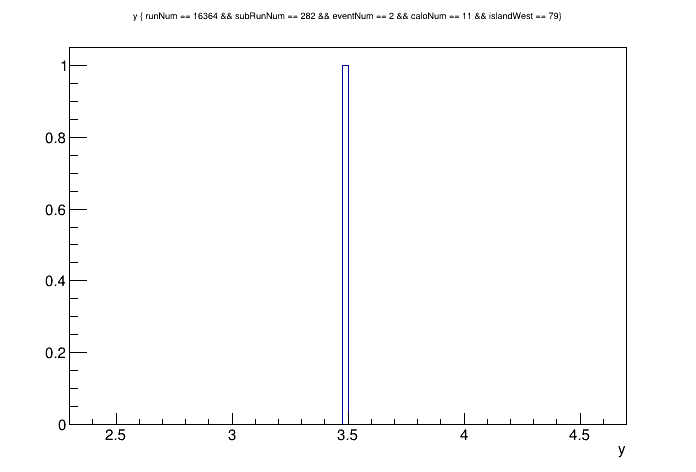

In [7]:
c = r.TCanvas()
twest.Draw("y",constructConditionFromUniqueIDWest(1636400282000020001100079),"")
c.Draw()

In [8]:
def toMap( crystalsInCluster ):
    xtalMapEast = []
    for i in range(54):
        if(i in crystalsInCluster):
            xtalMapEast.append(1)
        else:
            xtalMapEast.append(0)

    xtalMapEast.reverse()
    list1 = []
    list2 = []
    xtal = []
    list2xtal = []
    for crystal in range(54):
        list2.append(xtalMapEast[crystal]) 
        list2xtal.append(crystal)
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal.reverse()
            xtal.append(list2xtal)
            list2xtal = []
    xtal.reverse()
    
    return( list1 )

def arrangeXtals( vec1 ):
    vec1.reverse()
    list1 = []
    list2 = []
    for crystal in range(54):
        list2.append(vec1[crystal]) 
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal = []
    return(list1)

def imshowCompare(vec1, vec2, showPlot = True, titleString = ''):
    vec3 = []
    for i in range(len(vec1)):
        vec3i = []
        for j in range(len(vec1[0])):
            if(vec1[i][j] > 0.1 and vec2[i][j] > 0.1):
                vec3i.append(2) #both recons include this xtal
            elif (vec1[i][j] > 0.1):
                vec3i.append(1) #only recon east includes this crystal
            elif (vec2[i][j] > 0.1):
                vec3i.append(3) #only recon west
            else:
                vec3i.append(5) #not inluded in either recon's cluster.
        vec3.append(vec3i)
        
    fig, ax = plt.subplots()

    cmap = matplotlib.colors.ListedColormap(['blue', 'xkcd:teal green', 'xkcd:forest green', 'xkcd:light grey'])
    cmap.set_over('xkcd:light grey')
    cmap.set_under('xkcd:light grey')
    
    bounds = [1, 2, 3, 4]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    cax = ax.imshow(vec3, interpolation='nearest', cmap=cmap, vmin=1,vmax=5)
    ax.set_title('Crystals Identified as Part of Cluster(s) in \n Island '+str(titleString))
    cbar = fig.colorbar(cax,
                        cmap=cmap,
                        boundaries = [0] + bounds + [5],
                        extend='both',
                        extendfrac='auto',
                        spacing='uniform',
                        ticks=[x + 0.5 for x in bounds],
                        orientation='vertical')
    cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
    cbar.ax.set_yticklabels(['East Only', 'Both', 'West Only'])
          
    if(showPlot):
        plt.show()
    else:
        plt.close()
    
    return(vec3)

In [9]:
import time

In [10]:
t1 = time.time()
fout = r.TFile("ding.root","recreate")
tclone = twest.CopyTree("y>4")
t2 = time.time()

print(t2-t1, t1, t2)

0.8913836479187012 1540440602.6077025 1540440603.4990861


In [11]:
t1 = time.time()

vec = []
for i, entry in enumerate(twest):
    if(entry.y > 4):
        vec.append(i)

t2 = time.time()
print(t2-t1, t1, t2)

4.621769905090332 1540440603.5325835 1540440608.1543534


Unique island:  1636400282000020001100079
     Found Match ( 1000 1567 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [35.0]


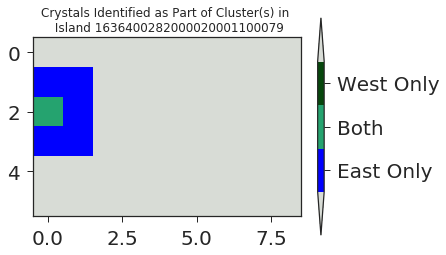

Unique island:  1636400282000020001100088
     Found Match ( 1001 1568 1 )
         East:  [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
         West:  [33.0, 13.0, 22.0, 32.0]


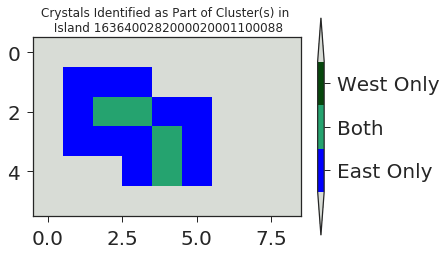

Unique island:  1636400282000020001100094
     Found Match ( 1002 1569 1 )
         East:  [13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 31.0, 32.0, 33.0]
         West:  [23.0, 14.0, 22.0, 13.0]


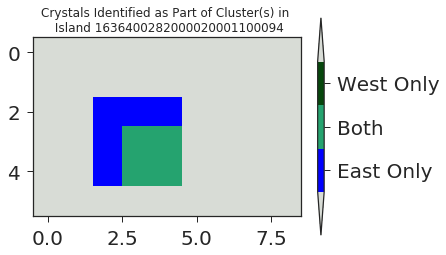

Unique island:  1636400282000020001100092
     Found Match ( 1003 1570 1 )
         East:  [7.0, 8.0, 16.0, 17.0, 25.0, 26.0]
         West:  [16.0, 17.0]


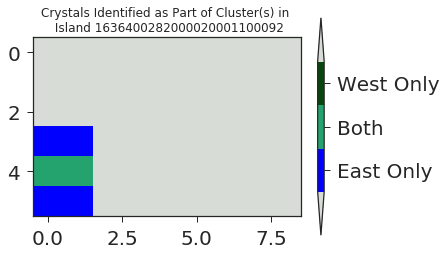

Unique island:  1636400282000020001100082
     Found Match ( 1004 1571 1 )
         East:  [18.0, 19.0, 27.0, 28.0, 36.0, 37.0]
         West:  [27.0, 18.0, 28.0]


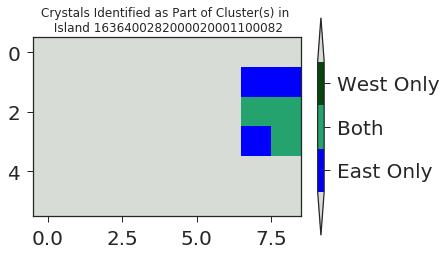

Unique island:  1636400282000020001100089
     Found Match ( 1005 1572 1 )
         East:  [22.0, 23.0, 24.0, 25.0, 26.0, 31.0, 32.0, 33.0, 34.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0]
         West:  [34.0, 33.0, 32.0]


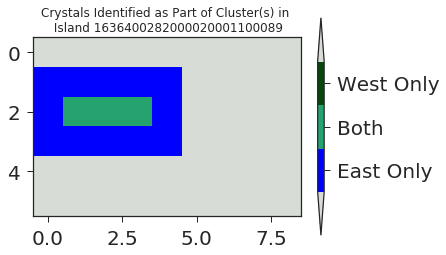

Unique island:  1636400282000020001100093
     Found another island with this unique ID. Adding their crystals together:
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0]
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 10.0, 11.0, 12.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0]
     Found Match ( 1006 1573 1 )
         East:  [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 10.0, 11.0, 12.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0]
         West:  [26.0, 34.0, 25.0, 19.0, 20.0, 33.0, 18.0, 27.0]


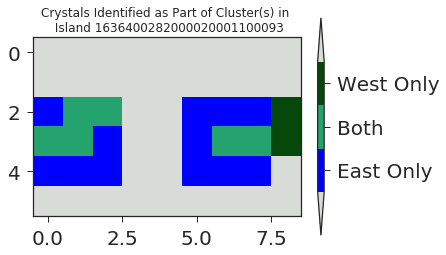

Unique island:  1636400282000020001100097
     Found Match ( 1008 1574 1 )
         East:  [5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0]
         West:  [6.0, 24.0, 15.0, 16.0]


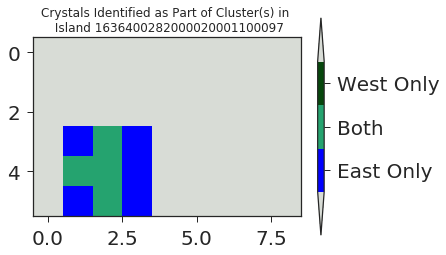

Unique island:  1636400282000020001100095
     Found Match ( 1009 1575 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [34.0, 25.0, 35.0]


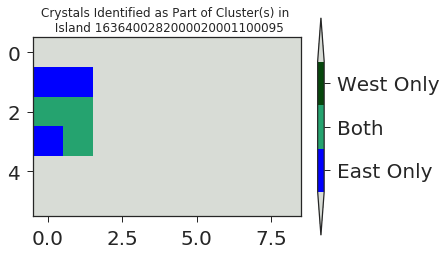

Unique island:  1636400282000020001100096
     Found Match ( 1010 1576 1 )
         East:  [6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0]
         West:  [16.0, 15.0]


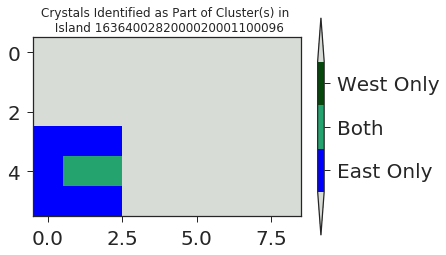

167.0199613571167 1540440608.1790152 1540440775.1989765


In [12]:
dingbefore = 0

t1 = time.time()

for i, entry in enumerate(teast):
    
    if i < 1000:
        continue
    if i > 1010:
        break
    
    counter = 0
    ding = constructUniqueIDeast(entry)
    if (dingbefore == ding):
        continue
        
    print("Unique island: ", ding)
    
    crystalsEast = [x for x in entry.crystalsEast]
    for k, entry3 in enumerate(teast):
        if i != k:
            dong = constructUniqueIDeast(entry3)
            if ding == dong:
                print("     Found another island with this unique ID. Adding their crystals together:")
                print("          ",crystalsEast)
                crystalsEast += [x for x in entry3.crystalsEast]
                print("          ",crystalsEast)
    
    crystalsWest = []
    for j, entry2 in enumerate(twest):
        dong = constructUniqueIDwest(entry2)
        if (ding == dong):
            counter = counter + 1
            print("     Found Match (", i, j, counter,")")
            print("         East: ", crystalsEast)
            print("         West: ", [x for x in entry2.crystalsWest])
            crystalsWest += [x for x in entry2.crystalsWest]
            
    imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, ding)

        
    dingbefore = ding
    
t2 = time.time()
print(t2-t1, t1, t2)

Unique island:  1636400282000020001100079
     Found another island with this unique ID. Adding their crystals together:
           [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
           [25.0, 26.0, 34.0, 35.0, 43.0, 44.0, 25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
     Found Match ( 1000 0 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0, 25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [35.0]


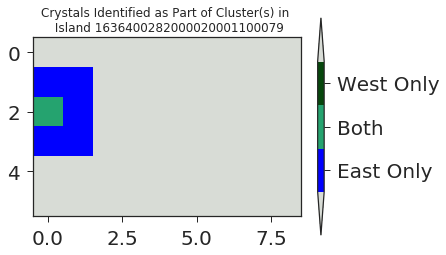

Unique island:  1636400282000020001100088
     Found another island with this unique ID. Adding their crystals together:
           [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
           [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0, 12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
     Found Match ( 1001 0 1 )
         East:  [12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0, 12.0, 13.0, 14.0, 21.0, 22.0, 23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0, 34.0, 41.0, 42.0, 43.0]
         West:  [33.0, 13.0, 22.0, 32.0]


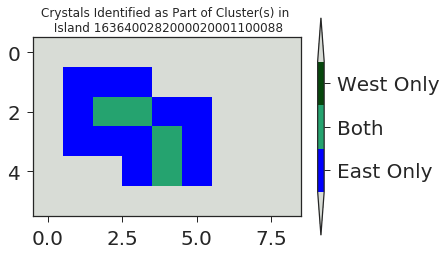

Unique island:  1636400282000020001100094
     Found another island with this unique ID. Adding their crystals together:
           [13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 31.0, 32.0, 33.0]
           [13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 31.0, 32.0, 33.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 31.0, 32.0, 33.0]
     Found Match ( 1002 0 1 )
         East:  [13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 31.0, 32.0, 33.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 31.0, 32.0, 33.0]
         West:  [23.0, 14.0, 22.0, 13.0]


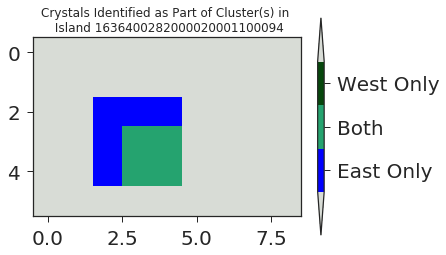

Unique island:  1636400282000020001100092
     Found another island with this unique ID. Adding their crystals together:
           [7.0, 8.0, 16.0, 17.0, 25.0, 26.0]
           [7.0, 8.0, 16.0, 17.0, 25.0, 26.0, 7.0, 8.0, 16.0, 17.0, 25.0, 26.0]
     Found Match ( 1003 0 1 )
         East:  [7.0, 8.0, 16.0, 17.0, 25.0, 26.0, 7.0, 8.0, 16.0, 17.0, 25.0, 26.0]
         West:  [16.0, 17.0]


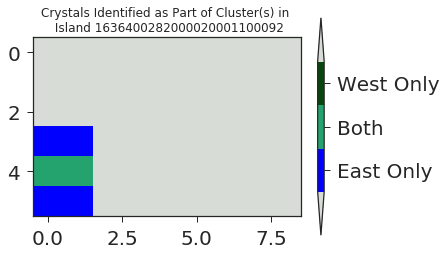

Unique island:  1636400282000020001100082
     Found another island with this unique ID. Adding their crystals together:
           [18.0, 19.0, 27.0, 28.0, 36.0, 37.0]
           [18.0, 19.0, 27.0, 28.0, 36.0, 37.0, 18.0, 19.0, 27.0, 28.0, 36.0, 37.0]
     Found Match ( 1004 0 1 )
         East:  [18.0, 19.0, 27.0, 28.0, 36.0, 37.0, 18.0, 19.0, 27.0, 28.0, 36.0, 37.0]
         West:  [27.0, 18.0, 28.0]


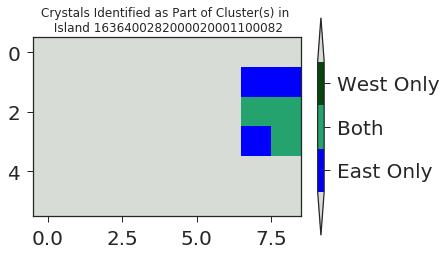

Unique island:  1636400282000020001100089
     Found another island with this unique ID. Adding their crystals together:
           [22.0, 23.0, 24.0, 25.0, 26.0, 31.0, 32.0, 33.0, 34.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0]
           [22.0, 23.0, 24.0, 25.0, 26.0, 31.0, 32.0, 33.0, 34.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0, 22.0, 23.0, 24.0, 25.0, 26.0, 31.0, 32.0, 33.0, 34.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0]
     Found Match ( 1005 0 1 )
         East:  [22.0, 23.0, 24.0, 25.0, 26.0, 31.0, 32.0, 33.0, 34.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0, 22.0, 23.0, 24.0, 25.0, 26.0, 31.0, 32.0, 33.0, 34.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0]
         West:  [34.0, 33.0, 32.0]


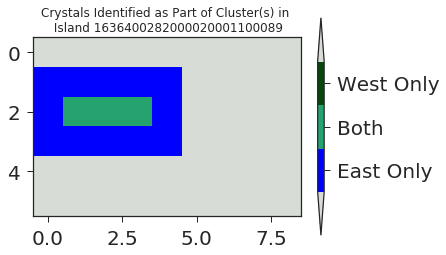

Unique island:  1636400282000020001100093
     Found another island with this unique ID. Adding their crystals together:
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0]
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0]
     Found another island with this unique ID. Adding their crystals together:
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0]
           [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 10.0, 11.0, 12.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0]
     Found Match ( 1006 0 1 )
         East:  [15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 33.0, 34.0, 35.0, 10.0, 11.0, 12.0, 19.0, 20.0, 21.0, 28.0, 29.0, 30.0]
         West:  [26.0, 34.0, 25.0, 19.0, 20.0, 33.0, 18.0, 27.0]


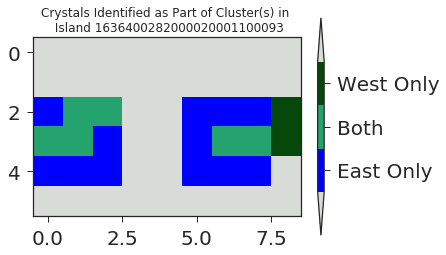

Unique island:  1636400282000020001100097
     Found another island with this unique ID. Adding their crystals together:
           [5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0]
           [5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0, 5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0]
     Found Match ( 1008 0 1 )
         East:  [5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0, 5.0, 6.0, 7.0, 14.0, 15.0, 16.0, 23.0, 24.0, 25.0]
         West:  [6.0, 24.0, 15.0, 16.0]


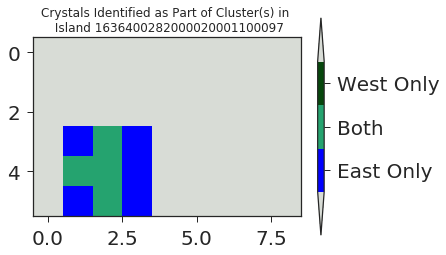

Unique island:  1636400282000020001100095
     Found another island with this unique ID. Adding their crystals together:
           [25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
           [25.0, 26.0, 34.0, 35.0, 43.0, 44.0, 25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
     Found Match ( 1009 0 1 )
         East:  [25.0, 26.0, 34.0, 35.0, 43.0, 44.0, 25.0, 26.0, 34.0, 35.0, 43.0, 44.0]
         West:  [34.0, 25.0, 35.0]


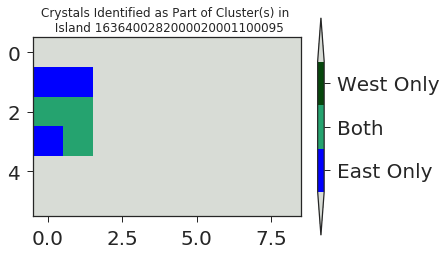

Unique island:  1636400282000020001100096
     Found another island with this unique ID. Adding their crystals together:
           [6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0]
           [6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0]
     Found Match ( 1010 0 1 )
         East:  [6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0, 6.0, 7.0, 8.0, 15.0, 16.0, 17.0, 24.0, 25.0, 26.0]
         West:  [16.0, 15.0]


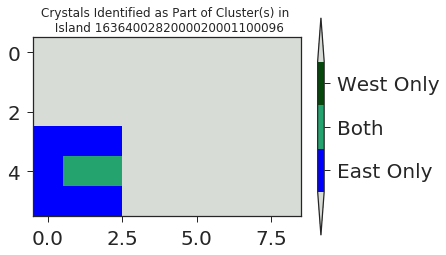

3.606851577758789 1540441007.761062 1540441011.3679135


In [17]:
dingbefore = 0

t1 = time.time()

for i, entry in enumerate(teast):
    
    if i < 1000:
        continue
    if i > 1010:
        break
    
    counter = 0
    ding = constructUniqueIDeast(entry)
    if (dingbefore == ding):
        continue
        
    print("Unique island: ", ding)
    
    crystalsEast = [x for x in entry.crystalsEast]
    
    fout = r.TFile("temp_tree_storage.root","recreate")
    
    teast_partial = teast.CopyTree( constructConditionFromUniqueIDEast(ding) )
    for k, entry3 in enumerate(teast_partial):
        dong = constructUniqueIDeast(entry3)
        if ding == dong:
            print("     Found another island with this unique ID. Adding their crystals together:")
            print("          ",crystalsEast)
            crystalsEast += [x for x in entry3.crystalsEast]
            print("          ",crystalsEast)
    
    
    twest_partial = twest.CopyTree( constructConditionFromUniqueIDWest(ding) )
    crystalsWest = []
    for j, entry2 in enumerate(twest_partial):
        dong = constructUniqueIDwest(entry2)
        if (ding == dong):
            counter = counter + 1
            print("     Found Match (", i, j, counter,")")
            print("         East: ", crystalsEast)
            print("         West: ", [x for x in entry2.crystalsWest])
            crystalsWest += [x for x in entry2.crystalsWest]
            
    imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, ding)

        
    dingbefore = ding
    
t2 = time.time()
print(t2-t1, t1, t2)